## 데이터 통합

In [2]:
import pandas as pd

# 파일 경로 및 정보
files = {
    "Nami Island": "gangwon_namiIsland.csv",
    "Seoraksan": "gangwon_mt.csv",
    "Bulguksa": "bulguksa.csv",
    "Hahoe Village": "andong_village.csv",
    "Andong Museum" : "andong_museum.csv",
    "Gyeongju Museum" : "gyeongju_museum.csv"
}

place_type = {
    "Nami Island": "traditional",
    "Seoraksan": "traditional",
    "Bulguksa": "history",
    "Hahoe Village": "history",
    "Andong Museum" : "museum",
    "Gyeongju Museum" : "museum"
}

encodings_to_try = ["utf-8", "cp949", "ISO-8859-1", "utf-16"]
columns = ["review"]

df_list = []

for place, path in files.items():
    for enc in encodings_to_try:
        try:
            df = pd.read_csv(path, encoding=enc, header=None)
            df = df.rename(columns={0: "review"})
            df["place"] = place
            df["type"] = place_type[place]
            df_list.append(df)
            print(f"{place} loaded successfully with encoding: {enc}")
            break
        except:
            continue

df_combined = pd.concat(df_list, ignore_index=True)


Nami Island loaded successfully with encoding: utf-8
Seoraksan loaded successfully with encoding: ISO-8859-1
Bulguksa loaded successfully with encoding: utf-8
Hahoe Village loaded successfully with encoding: utf-8
Andong Museum loaded successfully with encoding: utf-8
Gyeongju Museum loaded successfully with encoding: utf-8


In [2]:
df_combined.head()

,review,place,type
0,review,Nami Island,nature
1,최근순가장 최근의 게시 날짜를 기준으로 내림차순으로 정렬된 리뷰.상세 리뷰:대기 시...,Nami Island,nature
2,One Must Go!,Nami Island,nature
3,If in Seoul one must go. Very romantic and ext...,Nami Island,nature
4,From Seoul to Serenity: A Day on Nami Island N...,Nami Island,nature


In [3]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1579 entries, 0 to 1578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1579 non-null   object
 1   place   1579 non-null   object
 2   type    1579 non-null   object
dtypes: object(3)
memory usage: 37.1+ KB


In [3]:
df_combined['place'].unique()

array(['Nami Island', 'Seoraksan', 'Bulguksa', 'Hahoe Village',
       'Andong Museum', 'Gyeongju Museum'], dtype=object)

In [4]:
# 시스템 문구 포함된 리뷰 제거
df_combined = df_combined[~df_combined["review"].str.contains(
    "Most Recent:Reviews ordered by most recent publish date",
    case=False,
    na=False
)]

# 2. 첫 번째 행에 'review' 텍스트가 들어간 경우 제거
df_combined = df_combined[df_combined["review"] != "review"]

# 3. 결측치(NaN) 및 공백("") 리뷰 제거
df_combined = df_combined[df_combined["review"].notna()]  # NaN 제거
df_combined = df_combined[df_combined["review"].str.strip() != ""]  # 빈 문자열 제거

# 4. 인덱스 초기화
df_combined.reset_index(drop=True, inplace=True)


In [5]:
import re, html, unicodedata

def normalize_text(x: str) -> str:
    x = html.unescape(str(x))
    x = unicodedata.normalize("NFKC", x)
    return x.strip()

# 1) 텍스트 정규화
df_combined["review"] = df_combined["review"].astype(str).map(normalize_text)

# 2) 헤더 문자열 제거 (대소문자/공백 대응)
df_combined = df_combined[df_combined["review"].str.strip().str.lower() != "review"]

# 3) 시스템 문구 제거 (영/한 동시 대응)
pat_sys = re.compile(
    r"(most\s*recent\s*:?\s*reviews.*?publish\s*date)"
    r"|((최근순|가장\s*최근).*(내림차순|정렬).*(리뷰))",
    re.I
)
df_combined = df_combined[~df_combined["review"].fillna("").str.contains(pat_sys)]

# 4) 공백/중복 제거
df_combined = df_combined[df_combined["review"] != ""]
df_combined = df_combined.drop_duplicates(subset=["review","place"]).reset_index(drop=True)

print(df_combined.head(5))
print(f"[INFO] reviews after clean: {len(df_combined):,}")

                                              review        place         type
0                                       One Must Go!  Nami Island  traditional
1  If in Seoul one must go. Very romantic and ext...  Nami Island  traditional
2  From Seoul to Serenity: A Day on Nami Island N...  Nami Island  traditional
3  Nami Island - yeah Was great to see the island...  Nami Island  traditional
4  A Scenic Escape Influenced by K-Drama A visit ...  Nami Island  traditional
[INFO] reviews after clean: 1,485


/tmp/ipython-input-610981042.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_combined = df_combined[~df_combined["review"].fillna("").str.contains(pat_sys)]


## 1.부정 축약형 정규화 (normalize_neg)

- 리뷰에는 don't, can't, isn't, won't… 같은 축약형 부정 존재

- 전처리/토큰화 과정에서 '(apostrophe)를 제거 시 don't → don t처럼 부정 신호가 깨질 위험 존재

- 축약형을 일괄적으로 not으로 치환해, 부정 신호를 안정적으로 보존
  ex) isn't good → not good

In [6]:
import re
_contr_pat = re.compile(
    r"\b(can't|cannot|don't|doesn't|didn't|won't|wouldn't|shouldn't|isn't|aren't|wasn't|weren't|haven't|hasn't|hadn't|n't)\b",
    re.I
)

def normalize_neg(text: str) -> str:
    return _contr_pat.sub(" not", text)

## 2.문장분할(Sentence Split)

리뷰 전체 평균만 보면, 강한 부정/긍정 문장이 묻힐 수 있음.


같은 리뷰 안에서도 문장마다 감정이 다를 수 있음을 고려.

In [7]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt', quiet=True)

rows = []
sid = 0
for i, r in df_combined.iterrows():
    # 1) 부정 축약형 먼저 정규화하여 부정 신호 보존
    tx = normalize_neg(r["review"])
    # 2) 문장 분할
    sents = [s.strip() for s in sent_tokenize(tx) if s.strip()]
    for s in sents:
        rows.append({
            "doc_id": i,            # 원 리뷰 인덱스
            "sent_id": sid,         # 문장 고유 ID
            "place": r["place"],    # 메타 유지
            "type":  r["type"],
            "sentence": s           # 문장 원문(부정만 정규화됨)
        })
        sid += 1

df_sent = pd.DataFrame(rows)
print(f"[INFO] sentences: {len(df_sent):,}")
df_sent.head(5)

[INFO] sentences: 7,360


,doc_id,sent_id,place,type,sentence
0,0,0,Nami Island,traditional,One Must Go!
1,1,1,Nami Island,traditional,If in Seoul one must go.
2,1,2,Nami Island,traditional,Very romantic and extra ordinary place in this...
3,1,3,Nami Island,traditional,Starting from the road leading to the ferry te...
4,1,4,Nami Island,traditional,Next will be the queue for the ferry.


In [9]:
%%capture
!pip install langdetect

## 3.VADER 감성 스코어 + 라벨링

### 3-1.한국어 리뷰 번역

<한국어 리뷰 섞여 있음>

영어 리뷰만 추출하려고 해도, 언어 필터가 영어로 확실히 고정되지 않았거나,

자동 번역 on/off 상태에 따라 실제 HTML/JSON에 한국어 원문이 일부 포함됐을 가능성(한국어로 번역된 리뷰 약 8%확인)

: 번역을 통해 해결 (삭제할지 고민했으나 필터를 영어로 이미 설정한 후의 일이므로 번역하기로 결정)

In [10]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # 재현성 보장

def detect_lang_safe(text):
    try:
        return detect(text)
    except:
        return "unknown"

# 문장 단위로 언어 감지
df_sent["lang"] = df_sent["sentence"].apply(detect_lang_safe)

# 전체 분포 확인
lang_counts = df_sent["lang"].value_counts(normalize=True) * 100
print(lang_counts)


lang
en         87.255435
ko          8.423913
unknown     1.725543
fr          0.421196
ro          0.366848
af          0.326087
de          0.217391
et          0.203804
no          0.149457
id          0.149457
nl          0.095109
pl          0.095109
it          0.095109
tl          0.081522
fi          0.054348
cy          0.054348
es          0.054348
ca          0.054348
lt          0.040761
da          0.027174
so          0.027174
tr          0.013587
vi          0.013587
sk          0.013587
sw          0.013587
hr          0.013587
sq          0.013587
Name: proportion, dtype: float64


In [11]:
%%capture
!pip install deep-translator

In [12]:
from deep_translator import GoogleTranslator

gt = GoogleTranslator(source='ko', target='en')

def translate_ko_to_en(text: str) -> str:
    if not isinstance(text, str) or not text.strip():
        return text
    try:
        return gt.translate(text)
    except Exception:
        # 실패 시 원문 유지 (나중에 로그 보고 재시도 가능)
        return text

def to_scoring_text(row):
    s = row["sentence"]
    # 한국어만 번역, 그 외는 원문 사용
    if row.get("lang", "en") == "ko":
        return translate_ko_to_en(s)
    return s

# 분석용 문장 컬럼 생성
df_sent["sentence_for_scoring"] = df_sent.apply(to_scoring_text, axis=1)

In [13]:
# CSV로 저장
df_sent.to_csv("df_sent_with_sentiment.csv", index=False, encoding="utf-8-sig")

# 저장 확인
print("[INFO] df_sent 저장 완료 → df_sent_with_sentiment.csv")
print(df_sent.head(3))

[INFO] df_sent 저장 완료 → df_sent_with_sentiment.csv
   doc_id  sent_id        place         type  \
0       0        0  Nami Island  traditional   
1       1        1  Nami Island  traditional   
2       1        2  Nami Island  traditional   

                                            sentence lang  \
0                                       One Must Go!   de   
1                           If in Seoul one must go.   en   
2  Very romantic and extra ordinary place in this...   en   

                                sentence_for_scoring  
0                                       One Must Go!  
1                           If in Seoul one must go.  
2  Very romantic and extra ordinary place in this...  


In [1]:
import pandas as pd
from google.colab import files

# 파일 업로드
uploaded = files.upload()

# 업로드한 파일 읽기
df_sent = pd.read_csv("df_sent_with_sentiment.csv")
df_sent.head()

Saving df_sent_with_sentiment.csv to df_sent_with_sentiment.csv


,doc_id,sent_id,place,type,sentence,lang,sentence_for_scoring
0,0,0,Nami Island,nature,One Must Go!,de,One Must Go!
1,1,1,Nami Island,nature,If in Seoul one must go.,en,If in Seoul one must go.
2,1,2,Nami Island,nature,Very romantic and extra ordinary place in this...,en,Very romantic and extra ordinary place in this...
3,1,3,Nami Island,nature,Starting from the road leading to the ferry te...,en,Starting from the road leading to the ferry te...
4,1,4,Nami Island,nature,Next will be the queue for the ferry.,en,Next will be the queue for the ferry.


### 3-2. VANDER

VADER는 한 문장에 대해 아래 4개 점수 반환

- pos (0~1): 긍정 비중

- neu (0~1): 중립 비중

- neg (0~1): 부정 비중

- compound (−1 ~ +1): 전체 감정을 하나로 요약한 점수
→ 이 compound로 최종 라벨을 정함.
<br>

라벨 기준:

- compound ≥ 0.05 → positive

- compound ≤ −0.05 → negative

- 그 사이 → neutral

In [14]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon', quiet=True)

True

In [15]:
sia = SentimentIntensityAnalyzer()

def vader_compound(s: str) -> float:
    try:
        return float(sia.polarity_scores(s)["compound"])
    except Exception:
        return 0.0

def label_from_compound(c: float) -> str:
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

# 점수/라벨 부여
df_sent["compound"]   = df_sent["sentence_for_scoring"].map(vader_compound)
df_sent["sent_label"] = df_sent["compound"].map(label_from_compound)

- 제대로 분류되는지 확인

In [16]:
# 한국어리뷰확인
check_ko = (
    df_sent.query("lang == 'ko'")
           .head(10)[["sentence","sentence_for_scoring","compound","sent_label","place"]]
)
print(check_ko.to_string(index=False))

                                                                                     sentence                                                                                                                                                                                              sentence_for_scoring  compound sent_label       place
                                                    서울에서 꼭 가봐야 할 곳 남이섬은 제가 추천하는 매우 아름다운 곳입니다.                                                                                                                                               The must -see place in Seoul is a very beautiful place I recommend.    0.7880   positive Nami Island
                                            이곳에서 키 큰 나무 아래를 걸어가거나 강변을 따라 산책하여 고요함을 즐길 수 있습니다.                                                                                                                  From here, you can walk down the tall tree or walk along the riverside to enjoy the tranquility.    0.7184   positive N

In [17]:
# 영어 리뷰 중 무작위 10개만 뽑아서 제대로 작동하는지 확인
check_en = (
    df_sent.query("lang == 'en'")
           .sample(10, random_state=42)[["sentence","sentence_for_scoring","compound","sent_label","place"]]
)

print(check_en.to_string(index=False))

                                                                                                                               sentence                                                                                                                    sentence_for_scoring  compound sent_label           place
                                                                                    The place is wonderful especially who likes nature.                                                                                     The place is wonderful especially who likes nature.    0.7769   positive     Nami Island
                                                                                                    We enjoyed biking the whole island.                                                                                                     We enjoyed biking the whole island.    0.5106   positive     Nami Island
                                                                         

➡︎ 긍·부정 키워드가 있는 문장은 잘 감지함.

➡︎ 단순 설명이나 약한 감정은 중립 처리

## 4.감성 분포 요약 (장소/유형별)


[전체 요약]
 n_sent  pos_rate  neg_rate  neu_rate  mean_compound
   7360  0.603668  0.079076  0.317255       0.313839

[장소별 요약]
          place        type  n_sent  pos_rate  neg_rate  neu_rate  mean_compound
  Andong Museum      museum     171  0.614035  0.070175  0.315789       0.284761
       Bulguksa     history    1066  0.659475  0.065666  0.274859       0.370941
Gyeongju Museum      museum    1097  0.637192  0.058341  0.304467       0.323286
  Hahoe Village     history    1152  0.570312  0.096354  0.333333       0.271518
    Nami Island traditional    2356  0.588285  0.074703  0.337012       0.310497
      Seoraksan traditional    1518  0.588274  0.098155  0.313570       0.307494


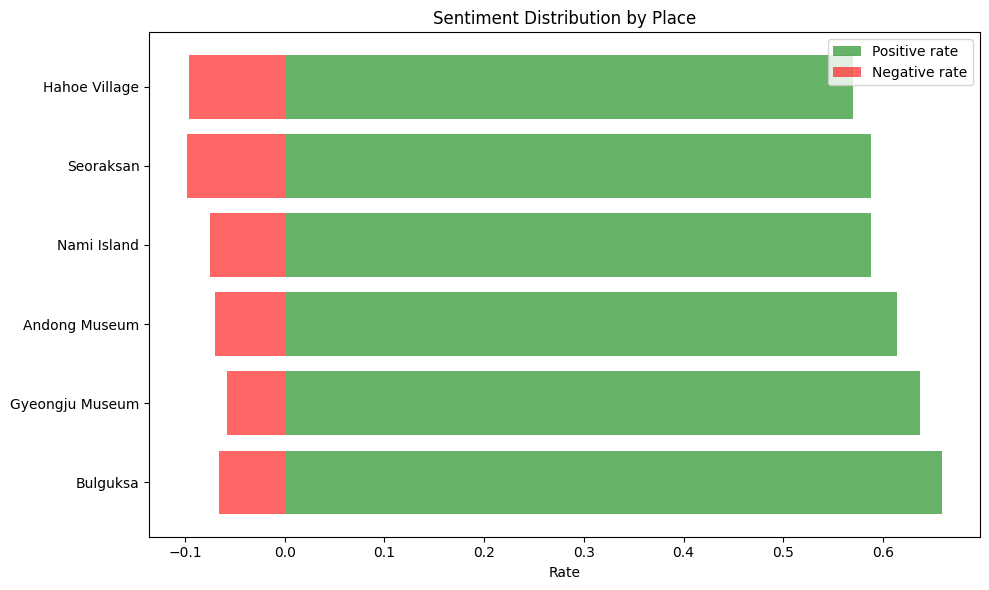

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 라벨을 더미로 변환
df_sent = df_sent.assign(
    pos=(df_sent["sent_label"]=="positive").astype(int),
    neg=(df_sent["sent_label"]=="negative").astype(int),
    neu=(df_sent["sent_label"]=="neutral").astype(int)
)

# (1) 전체 요약
overall_summary = pd.DataFrame({
    "n_sent": [len(df_sent)],
    "pos_rate": [df_sent["pos"].mean()],
    "neg_rate": [df_sent["neg"].mean()],
    "neu_rate": [df_sent["neu"].mean()],
    "mean_compound": [df_sent["compound"].mean()]
})
print("\n[전체 요약]")
print(overall_summary.to_string(index=False))

# (2) 장소별 요약
place_summary = (
    df_sent
    .groupby(["place","type"], as_index=False)
    .agg(n_sent=("sentence","count"),
         pos_rate=("pos","mean"),
         neg_rate=("neg","mean"),
         neu_rate=("neu","mean"),
         mean_compound=("compound","mean"))
)

print("\n[장소별 요약]")
print(place_summary.to_string(index=False))

# (3) 시각화: 장소별 긍·부정 비율 막대 그래프
fig, ax = plt.subplots(figsize=(10,6))

# 긍정과 부정 비율만 표시 (중립은 제외 가능)
place_summary_sorted = place_summary.sort_values("pos_rate", ascending=False)

ax.barh(place_summary_sorted["place"], place_summary_sorted["pos_rate"], color="green", alpha=0.6, label="Positive rate")
ax.barh(place_summary_sorted["place"], -place_summary_sorted["neg_rate"], color="red", alpha=0.6, label="Negative rate")

ax.set_xlabel("Rate")
ax.set_title("Sentiment Distribution by Place")
ax.legend()

plt.tight_layout()
plt.show()

## 5.문장 단위 감성 검증을 통해 감성분석을 교차 검증

### 5-1. Traditional(남이섬, 설악산)

In [20]:
# 1) traditional 카테고리만 필터링
df_nature = df_sent[df_sent["type"] == "traditional"].copy()

# 2) 키워드 후보 (네트워크 기반)
traditional_keywords = [
    "also","around","autumn","beautiful","could","day","ferry","get","go",
    "good","great","hours","island","korea","korean","many","much","must",
    "nami","nice","one","photos","place","restaurants","see","seoul",
    "sonata","take","time","tour","trip","trees","visit","winter","would"
]

# 3) 문장 단위 감성 검증
results = []
for kw in traditional_keywords:
    mask = df_nature["sentence_for_scoring"].str.contains(kw, case=False, na=False)
    subset = df_nature[mask]
    if len(subset) > 0:
        results.append({
            "keyword": kw,
            "n_sent": len(subset),
            "pos_rate": (subset["sent_label"]=="positive").mean(),
            "neg_rate": (subset["sent_label"]=="negative").mean(),
            "mean_compound": subset["compound"].mean()
        })

df_kw_sentiment_nature = pd.DataFrame(results).sort_values("n_sent", ascending=False)
print(df_kw_sentiment_nature)

        keyword  n_sent  pos_rate  neg_rate  mean_compound
26                 3874  0.588281  0.083893       0.309321
16                 3874  0.588281  0.083893       0.309321
4                  3874  0.588281  0.083893       0.309321
30                 3874  0.588281  0.083893       0.309321
29                 3874  0.588281  0.083893       0.309321
20                 3874  0.588281  0.083893       0.309321
12       island     740  0.660811  0.056757       0.383366
8            go     498  0.704819  0.074297       0.402224
22        place     474  0.814346  0.063291       0.504502
32        visit     452  0.747788  0.053097       0.424737
18         nami     377  0.679045  0.058355       0.394846
3     beautiful     355  1.000000  0.000000       0.742835
5           day     290  0.648276  0.082759       0.385476
27         take     258  0.565891  0.108527       0.293653
13        korea     252  0.738095  0.031746       0.449633
28         time     251  0.637450  0.143426       0.3411

### 5-2. History(불국사, 안동하회마을)

In [ ]:
# # 1) traditional 카테고리만 필터링
# df_nature = df_sent[df_sent["type"] == "traditional"].copy()

# # 2) 키워드 후보 (네트워크 기반)
# traditional_keywords = [
#     "also","around","autumn","beautiful","could","day","ferry","get","go",
#     "good","great","hours","island","korea","korean","many","much","must",
#     "nami","nice","one","photos","place","restaurants","see","seoul",
#     "sonata","take","time","tour","trip","trees","visit","winter","would"
# ]

# # 3) 문장 단위 감성 검증
# results = []
# for kw in traditional_keywords:
#     mask = df_nature["sentence_for_scoring"].str.contains(kw, case=False, na=False)
#     subset = df_nature[mask]
#     if len(subset) > 0:
#         results.append({
#             "keyword": kw,
#             "n_sent": len(subset),
#             "pos_rate": (subset["sent_label"]=="positive").mean(),
#             "neg_rate": (subset["sent_label"]=="negative").mean(),
#             "mean_compound": subset["compound"].mean()
#         })

# df_kw_sentiment_nature = pd.DataFrame(results).sort_values("n_sent", ascending=False)
# print(df_kw_sentiment_nature)

In [22]:
# traditional 카테고리만 필터링
# df_traditional = df_sent[df_sent["type"] == "traditional"].copy()

# traditional 키워드 후보 (의미연결망 기반)
traditional_keywords = [
    "also","around","autumn","beautiful","could","day","ferry","get","go",
    "good","great","hours","island","korea","korean","many","much","must",
    "nami","nice","one","photos","place","restaurants","see","seoul",
    "sonata","take","time","tour","trip","trees","visit","winter","would"
]

# history 카테고리만 필터링
# df_history = df_sent[df_sent["type"] == "history"].copy()

# history 키워드 후보 (의미연결망 기반)
history_keywords = [
    "also","andong","around","beautiful","buildings","bulguksa","buddhist","bus",
    "folk","get","great","gyeongju","hahoe","heritage","houses","korea","korean",
    "mask","must","nice","one","place","river","see","site","take","temple",
    "temples","traditional","unesco","village","visit","walk","well","worth","world"
]

# museum 카테고리만 필터링
# df_museum = df_sent[df_sent["type"] == "museum"].copy()

# museum  키워드 후보
museum_keywords = [
    "also","around","area","artifacts","beautiful","bell","buildings","different","dynasty",
    "english","exhibits","found","free","gold","good","great","grounds","gyeongju","history",
    "hours","interesting","kingdom","korea","korean","lot","many","museum","national","one",
    "place","see","shilla","silla","time","visit","visited","visiting","well","worth","would"
]

In [23]:
import pandas as pd

def kw_sentiment(df, keywords, type_value=None):

    if type_value is not None:
        df = df[df["type"] == type_value]

    rows = []
    for kw in keywords:
        m = df["sentence_for_scoring"].str.contains(kw, case=False, na=False)
        sub = df[m]
        if not sub.empty:
            rows.append({
                "keyword": kw,
                "n_sent": len(sub),
                "pos_rate": (sub["sent_label"] == "positive").mean(),
                "neg_rate": (sub["sent_label"] == "negative").mean(),
                "mean_compound": sub["compound"].mean(),
            })
    return (pd.DataFrame(rows)
              .sort_values("n_sent", ascending=False)
              .reset_index(drop=True))


- n_sent: 그 키워드가 들어간 문장 수(표본 크기).

- pos_rate / neg_rate: 해당 문장 중 긍정/부정 라벨 비율.

- mean_compound: 문장 감성 점수 평균(보통 −1~1). <br> 0.5±는 강한 긍정, 0.35 전후는 약한 긍정/중립에 가깝

In [24]:
# traditional
kw_sentiment(df_sent, traditional_keywords, type_value="traditional")

,keyword,n_sent,pos_rate,neg_rate,mean_compound
0,island,740,0.660811,0.056757,0.383366
1,go,498,0.704819,0.074297,0.402224
2,place,474,0.814346,0.063291,0.504502
3,visit,452,0.747788,0.053097,0.424737
4,nami,377,0.679045,0.058355,0.394846
5,beautiful,355,1.000000,0.000000,0.742835
6,day,290,0.648276,0.082759,0.385476
7,one,278,0.690647,0.082734,0.390498
8,take,258,0.565891,0.108527,0.293653
9,tour,256,0.613281,0.105469,0.331490


In [25]:
# history
kw_sentiment(df_sent, history_keywords, type_value="history")

,keyword,n_sent,pos_rate,neg_rate,mean_compound
0,village,411,0.630170,0.092457,0.333381
1,temple,382,0.761780,0.034031,0.467386
2,visit,312,0.782051,0.038462,0.456366
3,bus,282,0.503546,0.177305,0.209062
4,korea,242,0.727273,0.066116,0.416655
5,one,214,0.672897,0.074766,0.380453
6,place,211,0.744076,0.080569,0.438070
7,see,199,0.693467,0.080402,0.374691
8,beautiful,187,0.967914,0.021390,0.712635
9,site,170,0.682353,0.047059,0.409582


In [26]:
# museum
kw_sentiment(df_sent, museum_keywords, type_value="museum")

,keyword,n_sent,pos_rate,neg_rate,mean_compound
0,museum,373,0.691689,0.045576,0.372645
1,history,148,0.709459,0.033784,0.388714
2,visit,142,0.746479,0.049296,0.369385
3,korea,139,0.654676,0.064748,0.354647
4,silla,113,0.663717,0.053097,0.348074
5,see,109,0.706422,0.055046,0.377022
6,well,98,0.938776,0.010204,0.487410
7,gyeongju,92,0.695652,0.054348,0.349316
8,one,91,0.714286,0.054945,0.396096
9,english,89,0.595506,0.000000,0.327296


## 6. 가중평균 오즈비

### [1] 문장에서 키워드 포함 여부/긍정 여부를 나눠 2×2 집계 (a,b,c,d)

In [9]:
def _weighted_table(df, exposed, positive, weight=None):
    w = weight if weight is not None else np.ones(len(df), dtype=float)
    a = w[ exposed &  positive].sum()  # 키워드 有 & 긍정
    b = w[ exposed & ~positive].sum()  # 키워드 有 & 부정
    c = w[~exposed &  positive].sum()  # 키워드 無 & 긍정
    d = w[~exposed & ~positive].sum()  # 키워드 無 & 부정
    return a,b,c,d

### [2] 오즈비와 신뢰구간 계산

In [10]:
import numpy as np

In [11]:
def _or_and_ci(a,b,c,d, add=0.5):
    a2,b2,c2,d2 = a+add,b+add,c+add,d+add  # 0회피 보정
    OR  = (a2*d2)/(b2*c2)                  # 오즈비 계산
    SE  = np.sqrt(1/a2 + 1/b2 + 1/c2 + 1/d2) # 표준오차
    lo  = np.exp(np.log(OR) - 1.96*SE)     # 하한
    hi  = np.exp(np.log(OR) + 1.96*SE)     # 상한
    return OR, lo, hi, SE

### [3] 장소별 OR + 가중 평균 OR

In [12]:
def stratified_weighted_or(df, keyword, strata_col="place",
                           text_col="sentence_for_scoring",
                           label_col="sent_label",
                           event_label="positive",
                           weight_col=None, regex=None):
    pat = re.compile(regex if regex else rf"\b{re.escape(keyword.lower())}\b", re.I)
    results = []

    for s, g in df.groupby(strata_col):
        txt = g[text_col].fillna("").str.lower()
        exposed  = txt.apply(lambda x: bool(pat.search(x))).values
        positive = (g[label_col].values == event_label)
        weight   = g[weight_col].values if (weight_col and weight_col in g.columns) else None

        a,b,c,d = _weighted_table(g, exposed, positive, weight)
        OR, lo, hi, SE = _or_and_ci(a,b,c,d)
        var = SE**2
        results.append({"place": s, "a":a,"b":b,"c":c,"d":d,
                        "OR":OR, "CI95":(lo,hi),
                        "logOR": np.log(OR), "var": var})

    res = pd.DataFrame(results)
    if res.empty:
        return {"by_place": res, "fixed_OR": np.nan, "fixed_CI95": (np.nan,np.nan)}

    # 가중 평균 OR (고정효과 메타분석: 역분산 가중)
    w = 1.0 / res["var"].values
    log_or = np.sum(w * res["logOR"]) / np.sum(w)
    se     = np.sqrt(1.0/np.sum(w))
    fixed_OR = float(np.exp(log_or))
    fixed_CI = (float(np.exp(log_or - 1.96*se)), float(np.exp(log_or + 1.96*se)))

    return {"by_place": res, "fixed_OR": fixed_OR, "fixed_CI95": fixed_CI}

In [14]:
import re
# 자연 관광지(Nami Island + Seoraksan)만 필터링
df_nature = df_sent[df_sent["type"]=="nature"].copy()

# 분석할 키워드 리스트
keywords = [
    "beautiful", "mountain", "car", "cable", "place", "visit", "park", "view", "seoraksan",
    "good", "must", "nice", "many",
    "temple", "korea", "hike", "hiking", "national", "autumn",
    "day", "see", "take", "time", "around", "also", "one",
    "nami", "island"
]

results = []

for kw in keywords:
    res = stratified_weighted_or(df_nature, kw, strata_col="place",
                                 text_col="sentence_for_scoring",
                                 label_col="sent_label",
                                 event_label="positive")
    results.append({
        "keyword": kw,
        "fixed_OR": res["fixed_OR"],
        "fixed_CI95_low": res["fixed_CI95"][0],
        "fixed_CI95_high": res["fixed_CI95"][1]
    })

df_or = pd.DataFrame(results).sort_values("fixed_OR", ascending=False)
df_or.head(10)  # OR 상위 10개만 미리보기

,keyword,fixed_OR,fixed_CI95_low,fixed_CI95_high
0,beautiful,281.338963,39.464133,2005.659492
11,nice,15.084335,7.392997,30.777391
9,good,14.740325,7.219840,30.094459
7,view,5.023631,2.891662,8.727461
4,place,3.926572,2.996985,5.144492
18,autumn,3.709941,2.524445,5.452155
5,visit,3.163887,2.349617,4.260345
14,korea,2.069467,1.422269,3.011170
25,one,1.911502,1.336692,2.733493
8,seoraksan,1.909120,1.228551,2.966697


**OR 해석**

- OR > 1: 해당 키워드가 언급된 문장은 그렇지 않은 문장보다 긍정일 오즈가 높음

- OR ≈ 1: 긍정 경향 차이가 거의 없음

- OR < 1: 오히려 부정 경향이 더 클 수 있음

### 인사이트

- **beautiful (281.3배, CI 39.5–2005.7)**
  - 압도적으로 강한 긍정 키워드.  
  - 신뢰구간이 매우 넓은 건, 키워드 등장 문장이 전부 긍정이라서 분산이 작기 때문 → 사실상 *“beautiful=거의 100% 긍정”*으로 해석.  

- **nice, good (~15배)**
  - 긍정 신호가 매우 강하게 작동하는 일반 감탄 키워드.  

- **view, place, autumn, visit (~3–5배)**
  - 경관(view), 장소(place), 계절(autumn), 방문(visit) 같은 핵심 관광 경험 관련 키워드들이 긍정을 높이는 경향.  
  - 이는 **자연 관광지의 차별적 매력 포인트**를 뒷받침.  

- **korea, one, seoraksan (~2배)**
  - 특정 지명·대상 언급도 긍정 경향을 보임.  
  - 특히 `seoraksan`은 *“place effect”*와 연결될 수 있음.  


### **보고서 정리 예시**

자연 관광지 리뷰에서 문장 단위 감성 분석을 기반으로 키워드별 오즈비를 계산한 결과, beautiful이 언급된 문장은 그렇지 않은 문장보다 긍정일 오즈가 약 281배 높았다. 일반 감탄 키워드(nice, good) 역시 각각 15배, 14.7배로 강한 긍정 경향을 보였다. 경관(view), 장소(place), 계절(autumn) 등 관광 경험 핵심 요소들은 3~5배 수준으로 긍정을 강화하는 것으로 나타났으며, 특정 지명(Seoraksan) 또한 긍정성과 유의미한 관련성을 보였다. 이는 자연 관광지 맥락에서 관광객의 긍정적 체험이 특정 키워드와 밀접히 연관됨을 시사한다.